<a href="https://colab.research.google.com/github/Parth-nXp/DNN_mini_project/blob/main/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
! pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud")

Skipping, found downloaded files in "./creditcardfraud" (use force=True to force download)


In [120]:
! pip install torchinfo

In [121]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import  AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
import numpy as np
import pandas as pd
from torchinfo import summary
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [122]:
data_df = pd.read_csv("/content/creditcardfraud/creditcard.csv")
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [123]:
original_df = data_df.copy()


In [124]:
X = np.array(data_df.iloc[:, :-1])
y = np.array(data_df.iloc[:, -1])

In [125]:
scaler  = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled.shape)
print(y.shape)


(284807, 30)
(284807,)


In [126]:
X_tensor = torch.from_numpy(X_scaled).float()
y_tensor = torch.from_numpy(y).float()
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size = 0.2)

In [128]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size = 2048, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 2048, shuffle = False)

In [129]:
class my_model(nn.Module):
  def __init__(self):
    super(my_model, self).__init__()
    self.layer1 = nn.Linear(30, 64)
    self.batch_norm1 = nn.BatchNorm1d(64)
    self.relu = nn.ReLU()
    self.dropout1 = nn.Dropout(0.5)
    self.layer2 = nn.Linear(64,32)
    self.batch_norm2 = nn.BatchNorm1d(32)
    self.dropout2 = nn.Dropout(0.3)
    self.layer3 = nn.Linear(32, 16)
    self.layer4 = nn.Linear(16,1)

  def forward(self, x):
    x = self.dropout1(self.relu(self.batch_norm1(self.layer1(x))))
    x = self.dropout2(self.relu(self.batch_norm2(self.layer2(x))))
    x = self.relu(self.layer3(x))
    x = self.layer4(x)
    return x


model = my_model().to(device)


In [130]:
summary(model, input_size= (2048, X.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
my_model                                 [2048, 1]                 --
├─Linear: 1-1                            [2048, 64]                1,984
├─BatchNorm1d: 1-2                       [2048, 64]                128
├─ReLU: 1-3                              [2048, 64]                --
├─Dropout: 1-4                           [2048, 64]                --
├─Linear: 1-5                            [2048, 32]                2,080
├─BatchNorm1d: 1-6                       [2048, 32]                64
├─ReLU: 1-7                              [2048, 32]                --
├─Dropout: 1-8                           [2048, 32]                --
├─Linear: 1-9                            [2048, 16]                528
├─ReLU: 1-10                             [2048, 16]                --
├─Linear: 1-11                           [2048, 1]                 17
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
Total mul

In [131]:
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
pos_weight = torch.tensor([num_neg  / num_pos]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
optimizer = AdamW(model.parameters(), lr = 0.001, weight_decay = 0.01)

In [132]:
total_loss_train_plot = []
total_loss_test_plot = []
total_recall_train_plot = []
total_recall_test_plot = []

epochs = 30

for epoch in range(epochs):
  train_loss = 0
  test_loss = 0
  y_true_train = []
  y_pred_train = []
  model.train()
  for data, label in train_dataloader:
    data = data.to(device)
    label = label.to(device)
    prediction = model(data).squeeze(-1)
    batch_loss = criterion(prediction, label)
    train_loss += batch_loss.item()
    y_true_train.append(label.cpu())
    y_pred_train.append((torch.sigmoid(prediction.cpu().detach()) > 0.5).float())

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
  y_true_train = torch.cat(y_true_train)
  y_pred_train = torch.cat(y_pred_train)
  total_recall_train_plot.append(recall_score(y_true_train.long(), y_pred_train.long()))
  model.eval()


  y_true_test = []
  y_pred_test = []
  with torch.no_grad():
    for data, label in test_dataloader:
      data = data.to(device)
      label = label.to(device)
      prediction = model(data).squeeze(-1)
      batch_loss = criterion(prediction, label)
      test_loss += batch_loss.item()
      y_true_test.append(label.cpu())
      y_pred_test.append((torch.sigmoid(prediction.cpu().detach()) > 0.5).float())


    y_true_test = torch.cat(y_true_test)
    y_pred_test = torch.cat(y_pred_test)
    total_recall_test_plot.append(recall_score(y_true_test.long(), y_pred_test.long()))
    total_loss_train_plot.append(train_loss / len(train_dataloader))
    total_loss_test_plot.append(test_loss / len(test_dataloader))

    print(f"Epoch: {epoch + 1}, Train Loss: {total_loss_train_plot[-1]}, Test Loss: {total_loss_test_plot[-1]}")
    print(f"Epoch: {epoch + 1}, Train Recall: {total_recall_train_plot[-1]}, Test Recall: {total_recall_test_plot[-1]}")
    print("="*30)

Epoch: 1, Train Loss: 0.8406922316976956, Test Loss: 0.527636145906789
Epoch: 1, Train Recall: 0.927860696517413, Test Recall: 0.9111111111111111
Epoch: 2, Train Loss: 0.46776014287024736, Test Loss: 0.33347576005118235
Epoch: 2, Train Recall: 0.8830845771144279, Test Recall: 0.9111111111111111
Epoch: 3, Train Loss: 0.4000148113284792, Test Loss: 0.30493522009679247
Epoch: 3, Train Recall: 0.8955223880597015, Test Recall: 0.9
Epoch: 4, Train Loss: 0.35515907619680676, Test Loss: 0.28651096512164387
Epoch: 4, Train Recall: 0.900497512437811, Test Recall: 0.9111111111111111
Epoch: 5, Train Loss: 0.322616556925433, Test Loss: 0.26899481990507673
Epoch: 5, Train Recall: 0.917910447761194, Test Recall: 0.9
Epoch: 6, Train Loss: 0.2872346455364355, Test Loss: 0.25459877241935047
Epoch: 6, Train Recall: 0.9203980099502488, Test Recall: 0.9111111111111111
Epoch: 7, Train Loss: 0.30837155313098, Test Loss: 0.26146068290940355
Epoch: 7, Train Recall: 0.917910447761194, Test Recall: 0.91111111111

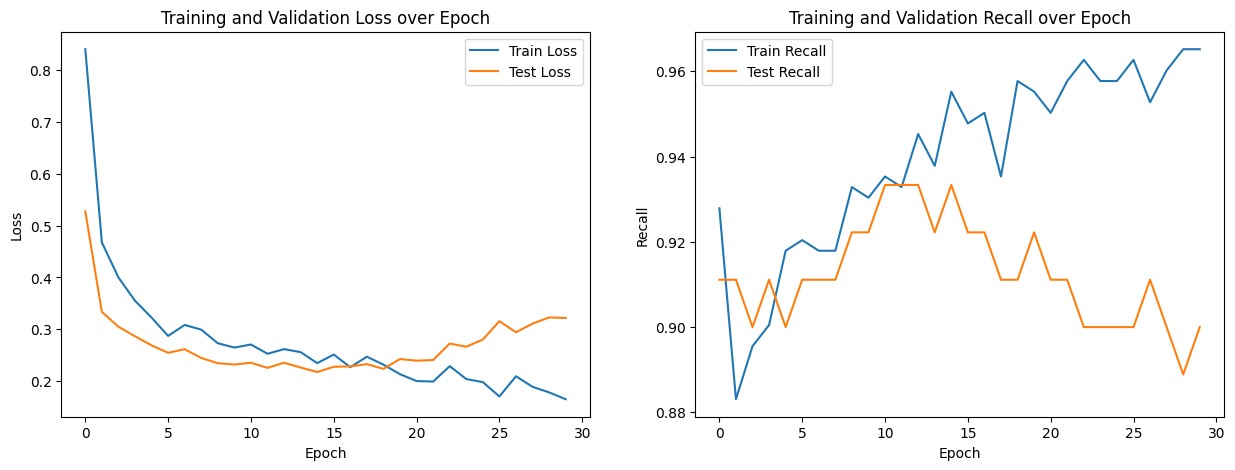

In [133]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
axs[0].plot(total_loss_train_plot, label = "Train Loss")
axs[0].plot(total_loss_test_plot, label = "Test Loss")
axs[0].set_title("Training and Validation Loss over Epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()


axs[1].plot(total_recall_train_plot, label = "Train Recall")
axs[1].plot(total_recall_test_plot, label = "Test Recall")
axs[1].set_title("Training and Validation Recall over Epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Recall")
axs[1].legend()

plt.show()